In [2]:
import torch, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch_esn.model.reservoir import Reservoir
from torch_esn.optimization.intrinsic_plasticity import IntrinsicPlasticity
from torch_esn.data.datasets.wesad import WESADDataset
from torch_esn.data.datasets.hhar import HHARDataset
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

from matplotlib.axes import Axes
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from exp.config import get_analysis

from typing import Optional, Tuple

sns.set_theme()

base_dir = "/home/decaro/federated-esn/experiments"
data_class = WESADDataset

colors = ["blue", "red", "purple", "green", "purple"]
if data_class == WESADDataset:
    states = ["baseline", "stress", "meditation", "amusement"]
else:
    states = data_class.CONTEXTS

patches = [
    Line2D([0], [0], linewidth=3, color="blue", label=states[0]),
    Line2D([0], [0], linewidth=3, color="red", label=states[1]),
    Line2D([0], [0], linewidth=3, color="purple", label=states[2]),
    Line2D([0], [0], linewidth=3, color="green", label=states[3]),
]

all_data = {
    k: [data_class(k, i) for i in range(len(data_class.CONTEXTS))]
    for k in data_class.USERS["all"]
}

# Data Analysis

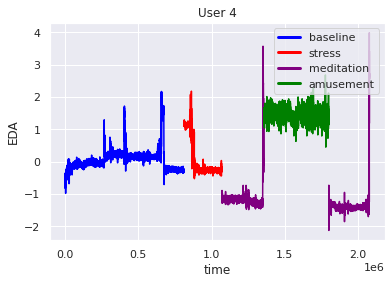

In [4]:
user = "4"
user_data = all_data[user]
first_idx = 0
for i, data in enumerate(user_data):
    last_idx = first_idx + data.data["X"].shape[0]
    ax = sns.lineplot(
        x=np.arange(first_idx, last_idx),
        y=data.data["X"].cpu().numpy()[:, 2],
        color=colors[i],
    )
    first_idx = last_idx
ax.set(title=f"User {user}", xlabel="time", ylabel="EDA")
ax.legend(handles=patches, loc="upper right")


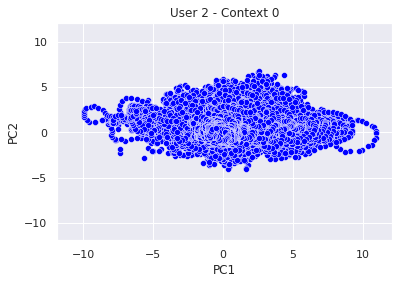

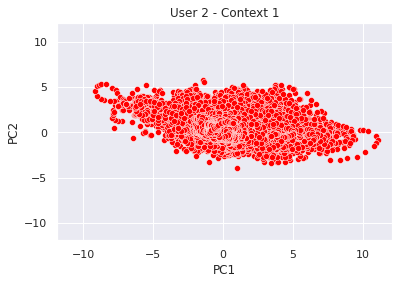

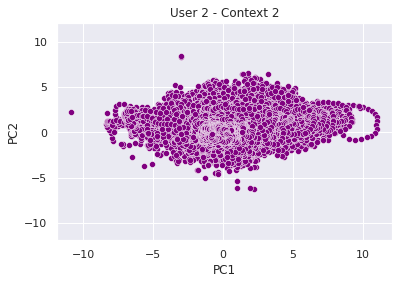

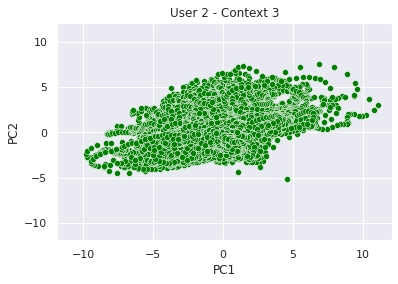

In [11]:
pca_Xs = []
min_v, max_v = float("+inf"), float("-inf")
for data in user_data:
    pca = PCA(n_components=2)
    pca_X = pca.fit_transform(data.data["X"].cpu().numpy())
    pca_Xs.append(pca_X)
    min_v, max_v = min(np.amin(pca_X), min_v), max(np.amax(pca_X), max_v)
min_v, max_v = min_v - 1, max_v + 1

for n, pca_X in enumerate(pca_Xs):
    ax = sns.scatterplot(x=pca_X[:, 0], y=pca_X[:, 1], color=colors[n])
    ax.set(
        title=f"User 2 - Context {n}",
        xlabel="PC1",
        ylabel="PC2",
        xlim=(min_v, max_v),
        ylim=(min_v, max_v),
    )
    plt.show()


## IP plots

In [3]:
def load_model(method: str, dataset: str, perc: int, context=None):
    if method in ["ridge", "ip"] or "continual_ip" in method:
        exp_dir = os.path.join(base_dir, "centralized")
    else:
        exp_dir = exp_dir = os.path.join(base_dir, "federated")
    exp_dir = os.path.join(exp_dir, f"{method}/{dataset}/{perc}")
    analysis = get_analysis("retraining", exp_dir)
    config = analysis.get_best_config("eval_acc", "max")
    mu, sigma = config["ip_args"]["mu"], config["ip_args"]["sigma"]
    checkpoint_path = analysis.get_best_checkpoint(
        analysis.get_best_trial("eval_acc", "max"), "eval_acc", "max", return_path=True
    )
    model = torch.load(os.path.join(checkpoint_path, "model.pkl"))
    reservoir = model["reservoir"] if context is None else model[context]["reservoir"]
    return reservoir, mu, sigma


def get_predictions(
    reservoir,
    user: str,
    context: int,
    proba: Optional[Tuple] = None,
    max_n_samples: Optional[int] = None,
):
    reservoir.eval()
    data = all_data[user][context]
    loader = DataLoader(data.features, batch_size=100, shuffle=False)
    pred = []
    n_samples = 0
    for x in loader:
        predictions = reservoir(x.to("cuda:0"))
        if proba is not None:
            mu, sigma = proba
            predictions = torch.exp(-((predictions - mu) ** 2 / sigma**2))
        pred.append(predictions.flatten().cpu().numpy())
        n_samples += x.shape[0] * x.shape[1]
        if max_n_samples is not None and n_samples >= max_n_samples:
            break
    pred = np.concatenate(pred)
    if max_n_samples is not None:
        return pred[:max_n_samples]
    return pred


def plot_user(
    reservoir,
    ax: Axes,
    user: str,
    proba: Optional[Tuple] = None,
    with_title: bool = False,
    with_legend: bool = False,
):
    preds = []
    for ctx in range(len(data_class.CONTEXTS)):
        ctx_pred = get_predictions(reservoir, user, ctx, proba, max_n_samples=500000)
        if proba is not None:
            mean, std = np.mean(ctx_pred), np.std(ctx_pred)
            ax.errorbar(
                x=ctx,
                y=mean,
                yerr=std,
                fmt="-o",
                color=colors[ctx],
                ecolor=colors[ctx],
                capsize=5,
            )
        else:
            sns.kdeplot(ctx_pred, color=colors[ctx], ax=ax)

    if proba is not None:
        if data_class == WESADDataset:
            ax.set_xticks(
                range(5),
                ["baseline", "stress", "meditation1", "amusement", "meditation2"],
                rotation=35,
            )
        else:
            ax.set_xticks(range(4), HHARDataset.CONTEXTS, rotation=35)
    else:
        ax.set_xlabel(("activation"))
        ax.set_xticks(np.arange(-1, 1.1, step=0.2))

    if with_legend:
        ax.legend(handles=patches, loc="upper right", fancybox=True, frameon=True)
    ax.set_title((f"User {user}" if with_title else ""))


def plot_density(dataset, method):
    test_users = data_class.USERS["test"]
    with plt.style.context("seaborn-whitegrid"):
        plt.rcParams["axes.edgecolor"] = "0.15"
        plt.rcParams["axes.linewidth"] = 1.25
        fig = plt.figure(figsize=(15, 15))
        gs = fig.add_gridspec(4, len(data_class.USERS["test"]), hspace=0.05, wspace=0)
        axs = gs.subplots(sharex="col", sharey="row")
        title = f"Reservoir activation density on test users with {'IP' if method == 'ip' else 'FedIP'}"
        fig.suptitle(title, fontsize=13, y=0.915)

        for i, perc in enumerate([25, 50, 75, 100]):
            print("Percentage:", perc)
            reservoir, mu, sigma = load_model(method, dataset, perc)
            reservoir.to("cuda")
            for j, u in enumerate(test_users):
                plot_user(
                    reservoir,
                    user=u,
                    ax=axs[i, j],
                    with_title=perc == 25,
                    with_legend=(j == len(test_users) - 1) and perc == 25,
                )
                if perc == 100:
                    axs[i, j].xaxis.set_major_locator(
                        MaxNLocator(nbins="auto", prune="both")
                    )
            ylabel = axs[i, 0].set_ylabel(
                f"TR users {perc}% "
                + r"($\mu = "
                + str(mu)
                + r", \sigma = "
                + str(round(sigma, 2))
                + "$)\n"
                + f"density"
            )
            axs[i, 0].yaxis.set_major_locator(MaxNLocator(nbins="auto", prune="both"))
        fig.tight_layout()
        curr_plot = plt
        return curr_plot, fig


def plot_likelihood(dataset, method):
    test_users = data_class.USERS["test"]
    with plt.style.context("seaborn-whitegrid"):
        plt.rcParams["axes.edgecolor"] = "0.15"
        plt.rcParams["axes.linewidth"] = 1.25
        fig = plt.figure(figsize=(15, 15))
        gs = fig.add_gridspec(4, len(test_users), hspace=0.05, wspace=0.025)
        axs = gs.subplots(sharex="col", sharey="row")
        title = f"Likelihood of activations on test users"
        fig.suptitle(title, fontsize=13, y=0.915)

        for i, perc in enumerate([25, 50, 75, 100]):
            reservoir, mu, sigma = load_model(method, dataset, perc)
            reservoir.to("cuda")
            for j, u in enumerate(test_users):
                plot_user(
                    reservoir,
                    user=u,
                    ax=axs[i, j],
                    proba=(mu, sigma),
                    with_title=perc == 25,
                    with_legend=(j == len(test_users) - 1) and perc == 25,
                )
            ylabel = axs[i, 0].set_ylabel(
                f"TR users {perc}% "
                + r"($\mu = "
                + str(mu)
                + r", \sigma = "
                + str(round(sigma, 2))
                + "$)\n"
                + f"likelihood"
            )
        fig.tight_layout()

        curr_plot = plt
        return curr_plot, fig


Percentage: 25
Percentage: 50
Percentage: 75
Percentage: 100


/tmp/ipykernel_2869749/1240772521.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


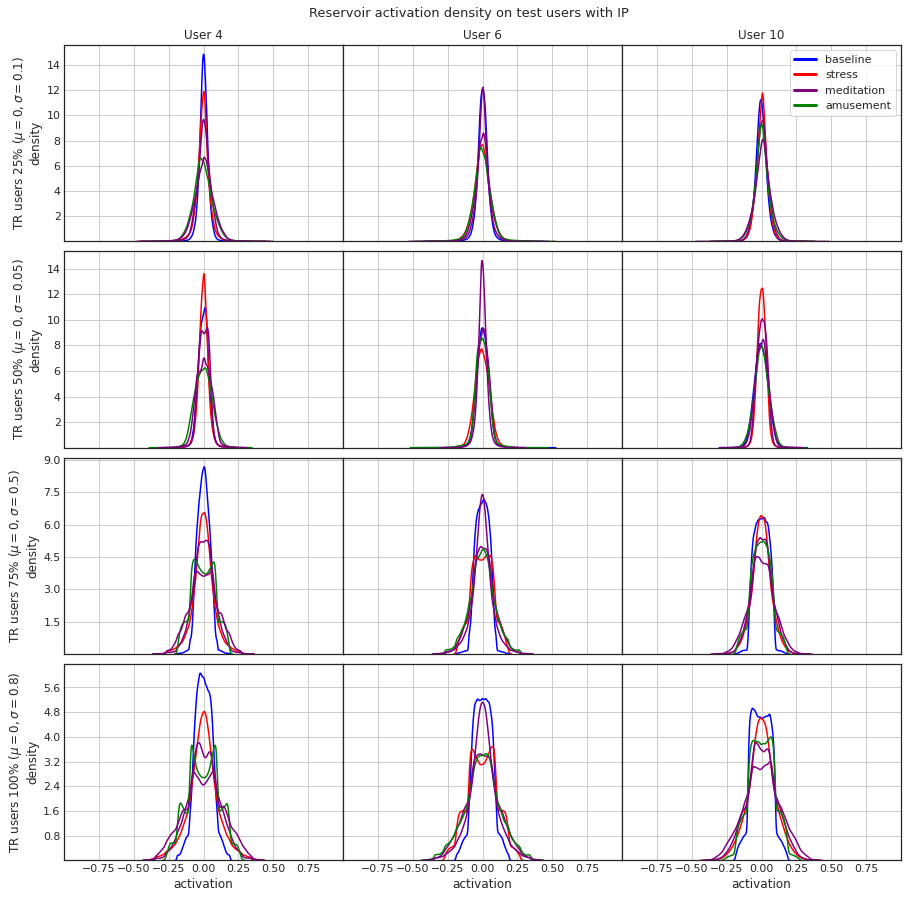

In [4]:
method = "ip"
curr_plot, fig = plot_density("WESAD", method)
plt.savefig(
    os.path.join(base_dir, f"img/reservoir_density_{method}.png"),
    dpi=300, 
    bbox_inches='tight')
curr_plot.show()

Percentage: 25
Percentage: 50
Percentage: 75
Percentage: 100


/tmp/ipykernel_2869749/1240772521.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


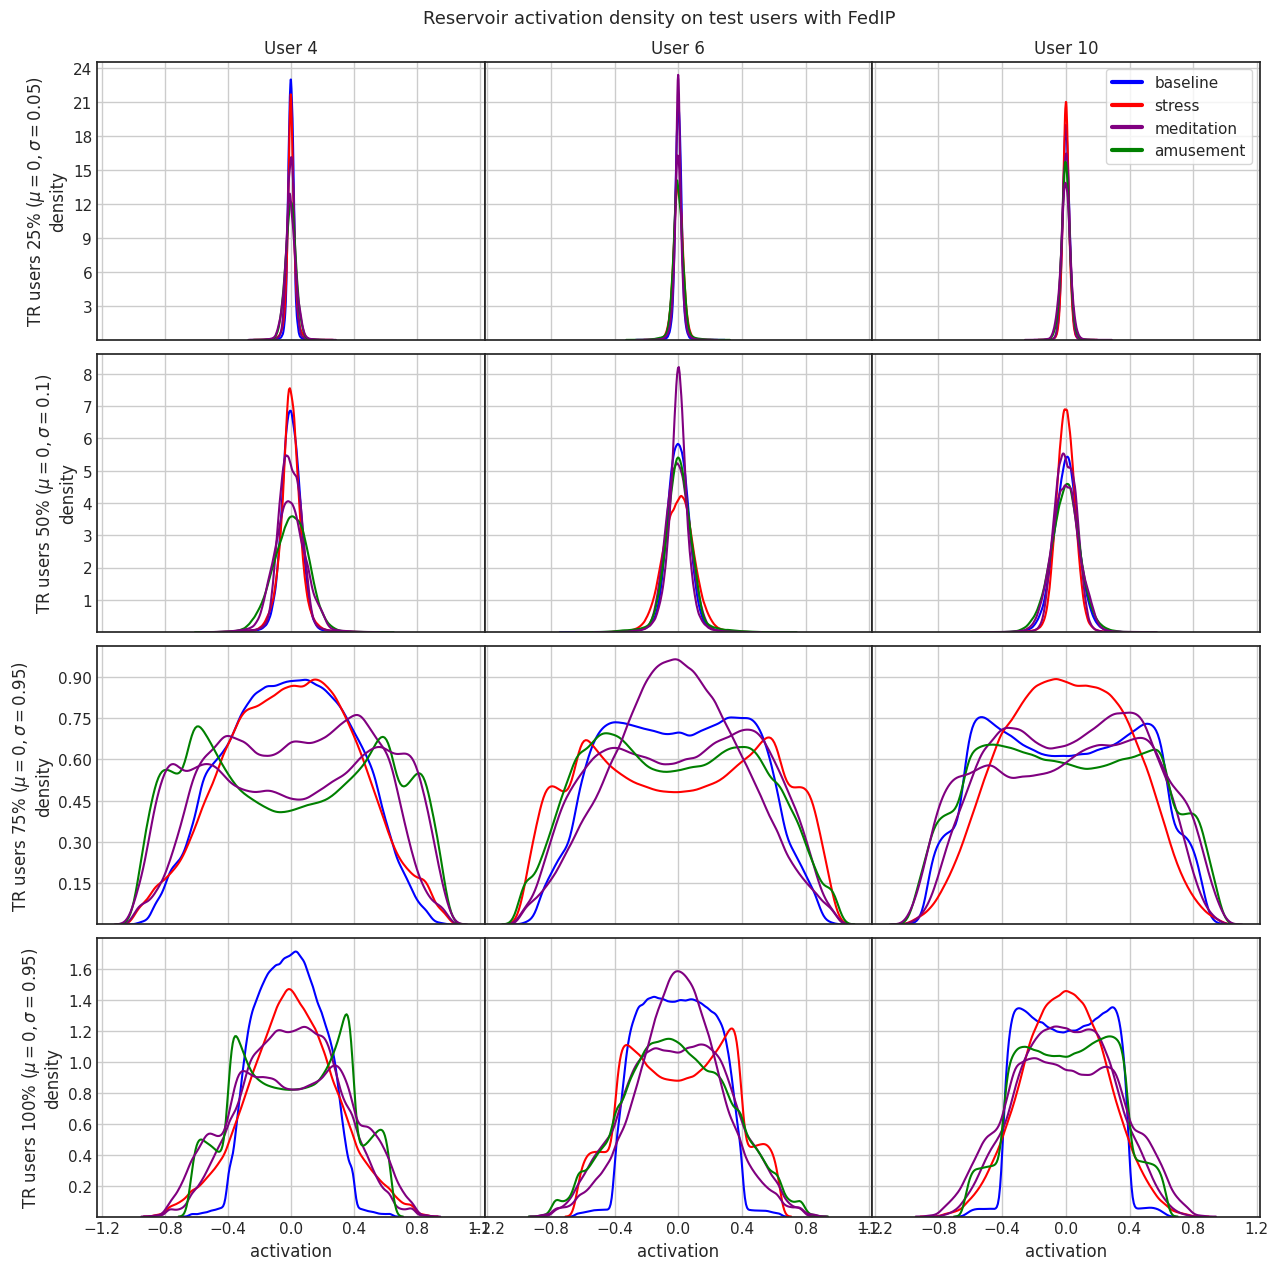

In [5]:
method = "fedip"
curr_plot, fig = plot_density("WESAD", method)
plt.savefig(
    os.path.join(base_dir, f"img/reservoir_density_{method}.png"),
    dpi=300, 
    bbox_inches='tight')
curr_plot.show()

# Results

In [4]:
import json
def get_str_res(method: str, dataset: str, perc: int):
    if method in ["ridge", "ip"] or "continual_ip" in method:
        exp_dir = (os.path.join(base_dir, "centralized"))
    else:
        exp_dir = exp_dir = (os.path.join(base_dir, "federated"))
    exp_dir = os.path.join(exp_dir, f"{method}/{dataset}/{perc}")
    res_file = os.path.join(exp_dir, "results")
    if method in ['incfed', 'ridge']:
        res = torch.load(open(res_file + ".pkl", 'rb'))
        json.dump(res, open(res_file + ".json", 'w'), indent=4)
    elif method in ['ip', 'fedip']:
        res = json.load(open(res_file + ".json"))
    res_str = (
        r"\res{"
        + str(round(np.mean(res) * 100, 2))
        + r"}{"
        + str(round(np.std(res) * 100, 2))
        + "}"
    )
    return res_str


In [9]:
methods = ["ridge", "ip"]
for perc in [25, 50, 75, 100]:
    line = [f"{perc}\\%"]
    for dataset in ["WESAD", "HHAR"]:
        for method in methods:
            line.append(get_str_res(method, dataset, perc))
    print(" & ".join(line) + r" \\")


25\% & \res{72.6}{1.24} & \res{78.14}{0.32} & \res{61.34}{3.19} & \res{68.82}{0.49} \\
50\% & \res{72.88}{1.35} & \res{76.98}{0.22} & \res{58.7}{5.29} & \res{66.64}{2.28} \\
75\% & \res{77.06}{1.02} & \res{78.68}{0.38} & \res{71.49}{0.93} & \res{70.33}{0.42} \\
100\% & \res{79.18}{0.4} & \res{78.89}{0.19} & \res{71.71}{0.72} & \res{70.88}{0.74} \\


# Continual Analysis

In [5]:
def collect_results(dataset, perc, method, strategy):
    if method == "continual_ip":
        exp_dir = os.path.join(base_dir, "centralized")
    else:
        exp_dir = os.path.join(base_dir, "federated")
    exp_dir = os.path.join(exp_dir, f"{method}_{strategy}/{dataset}/{perc}")
    analysis = get_analysis("retraining", exp_dir)
    cfg = analysis.get_best_config()
    mu, sigma = cfg["ip_args"]["mu"], cfg["ip_args"]["sigma"]
    checkpoint_dir = analysis.get_best_checkpoint(
        analysis.get_best_trial(), return_path=True
    )
    models = torch.load(os.path.join(checkpoint_dir, "model.pkl"))
    return models, mu, sigma

def plot_density_continual(dataset, perc, method, strategy):
    models, mu, sigma = collect_results(dataset, perc, method, strategy)
    if dataset == "WESAD":
        exp_names = ["baseline", "stress", "meditation1", "amusement", "meditation2"]
    else:
        exp_names = states
    
    with plt.style.context("seaborn-whitegrid"):
        plt.rcParams["axes.edgecolor"] = "0.15"
        plt.rcParams["axes.linewidth"] = 1.25
        fig = plt.figure(figsize=(15, 15))
        gs = fig.add_gridspec(
            len(data_class.CONTEXTS),
            len(data_class.USERS["test"]),
            hspace=0.05,
            wspace=0,
        )
        axs = gs.subplots(sharex="col", sharey="row")
        if method == 'continual_ip':
            title = f"Reservoir activation density - CLIP - {dataset} - {perc}%"
        else:
            title = f"Reservoir activation density - FedCLIP - {dataset} - {perc}%"
        fig.suptitle(title, fontsize=13, y=0.915)

        for i in range(len(data_class.CONTEXTS)):
            print("Context:", exp_names[i])
            reservoir = models[i]["reservoir"]
            reservoir.to("cuda")
            for j, user in enumerate(data_class.USERS["test"]):
                plot_user(
                    reservoir,
                    user=user,
                    ax=axs[i, j],
                    with_title=i == 0,
                    with_legend=(j == len(data_class.USERS["test"]) - 1) and i == 0,
                )
                if i == len(data_class.CONTEXTS) - 1:
                    axs[i, j].xaxis.set_major_locator(
                        MaxNLocator(nbins="auto", prune="both")
                    )
            ylabel = axs[i, 0].set_ylabel(f"{exp_names[i]}\ndensity")
            axs[i, 0].yaxis.set_major_locator(MaxNLocator(nbins="auto", prune="both"))
        fig.tight_layout()
        curr_plot = plt
        return curr_plot, fig

Context: baseline
Context: stress
Context: meditation1
Context: amusement
Context: meditation2


/tmp/ipykernel_2869749/1691900303.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 640x480 with 0 Axes>

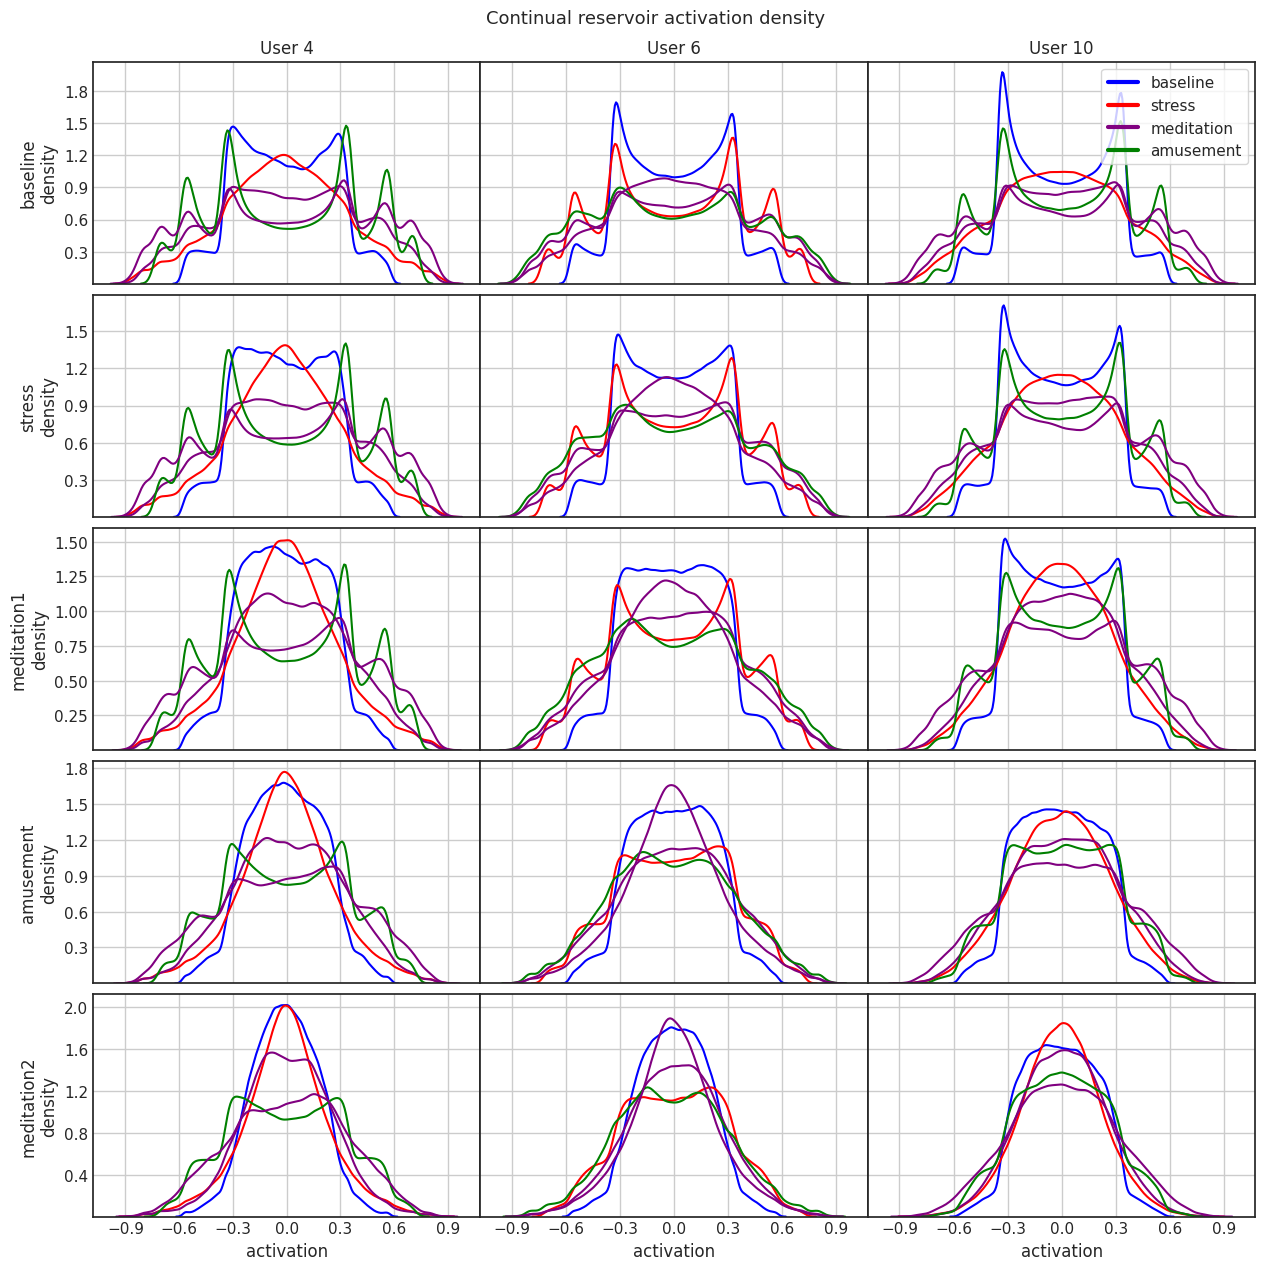

In [15]:
dataset = "WESAD" if data_class == WESADDataset else "HHAR"
for method in ["continual_ip", "continual_fedip"]:
    for strategy in ["naive", "replay"]:
        for perc in [25, 50, 75, 100]:
            curr_plot, fig = plot_density_continual(dataset, perc, method, strategy)
            plt.savefig(
                os.path.join(base_dir, f"img/{method}_{strategy}_{perc}.png"),
                dpi=300, 
                bbox_inches='tight')
            curr_plot.show()

In [6]:
# for each method, strategy, dataset, perc, line plot of the accuracy with standard deviation

def get_stream_acc(dataset, perc, method, strategy):
    if method == "continual_ip":
        exp_dir = os.path.join(base_dir, "centralized")
    else:
        exp_dir = os.path.join(base_dir, "federated")
    exp_dir = os.path.join(exp_dir, f"{method}_{strategy}/{dataset}/{perc}")
    results = json.load(open(os.path.join(exp_dir, "results.json")))
    stream_acc = [[res['stream'] for res in trial_res] for trial_res in results]
    return np.mean(stream_acc, axis=0)*100, np.std(stream_acc, axis=0)*100


In [8]:
get_stream_acc("WESAD", 25, "continual_ip", "joint")

(array([99.97051065, 77.82438371, 74.64057488, 76.88480777, 78.64457512]),
 array([0.01138815, 1.42917717, 0.85145991, 1.07922931, 0.89798265]))

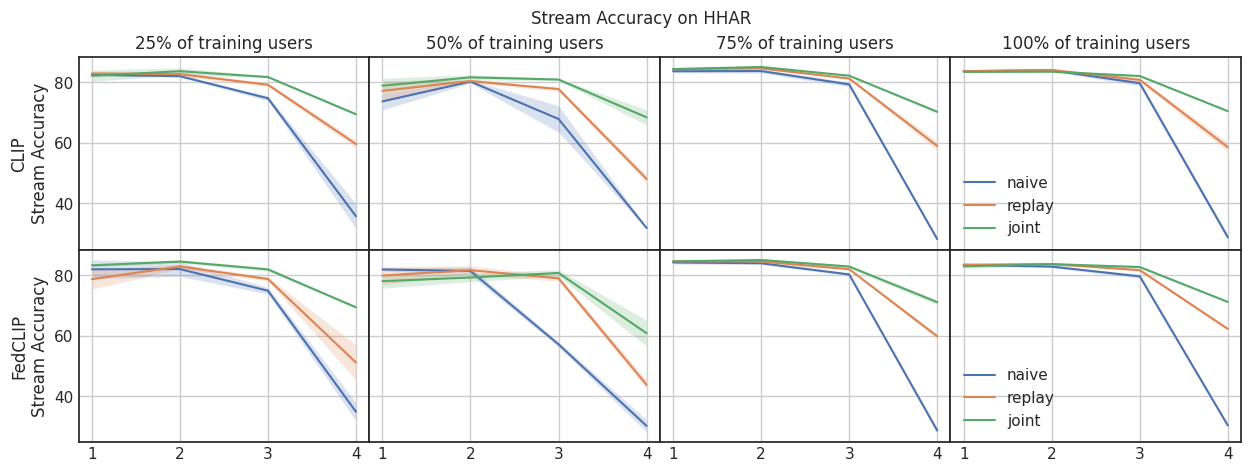

In [39]:
method = "continual_ip"

with plt.style.context("seaborn-whitegrid"):
        plt.rcParams["axes.edgecolor"] = "0.15"
        plt.rcParams["axes.linewidth"] = 1.25
        fig = plt.figure(figsize=(15, 5))
        gs = fig.add_gridspec(
            2,
            4,
            hspace=0,
            wspace=0,
        )
        axs = gs.subplots( sharey="row")
        fig.suptitle(f"Stream Accuracy on {dataset}", fontsize=12, y=0.975)
        for j, dataset in enumerate(["WESAD", "HHAR"]):
            if dataset == "WESAD":
                exp_labels = ["baseline", "stress", "meditation1", "amusement", "meditation2"]
            else:
                exp_labels = HHARDataset.CONTEXTS
            for i, perc in enumerate([25, 50, 75, 100]):
                ax = axs[j][i]
                for strategy in ["naive", "replay", "joint"]:
                    mean, std = get_stream_acc(dataset, perc, method, strategy)
                    label = strategy if perc == 100 else None
                    sns.lineplot(x=range(1, len(mean)+1), y=mean, label=label, ax=ax)
                    ax.fill_between(range(1, len(mean)+1), mean-std, mean+std, alpha=0.2)
                ax.set(ylabel=f"{dataset}\nStream Accuracy")
                if j == 0:
                    ax.set_title(f"{perc}% of training users")
        #fig.tight_layout()
        plt.savefig(
            os.path.join(base_dir, f"img/stream_acc_{dataset}.png"),
            dpi=300,
            bbox_inches='tight')
        
        plt.show()

In [29]:
def plot_density_continual_final(dataset, method, strategy):
    test_users = data_class.USERS["test"]
    with plt.style.context("seaborn-whitegrid"):
        plt.rcParams["axes.edgecolor"] = "0.15"
        plt.rcParams["axes.linewidth"] = 1.25
        fig = plt.figure(figsize=(15, 15))
        gs = fig.add_gridspec(4, len(data_class.USERS["test"]), hspace=0.05, wspace=0)
        axs = gs.subplots(sharex="col", sharey="row")
        title = f"Reservoir activation density on final experience with FedCLIP"
        fig.suptitle(title, fontsize=13, y=0.915)

        for i, perc in enumerate([25, 50, 75, 100]):
            print("Percentage:", perc)
            models, mu, sigma = collect_results(dataset, perc, method, strategy)
            reservoir = models[-1]["reservoir"]
            reservoir.to("cuda")
            for j, u in enumerate(test_users):
                plot_user(
                    reservoir,
                    user=u,
                    ax=axs[i, j],
                    with_title=perc == 25,
                    with_legend=(j == len(test_users) - 1) and perc == 25,
                )
                if perc == 100:
                    axs[i, j].xaxis.set_major_locator(
                        MaxNLocator(nbins="auto", prune="both")
                    )
            ylabel = axs[i, 0].set_ylabel(
                f"TR users {perc}% "
                + r"($\mu = "
                + str(mu)
                + r", \sigma = "
                + str(round(sigma, 2))
                + "$)\n"
                + f"density"
            )
            axs[i, 0].yaxis.set_major_locator(MaxNLocator(nbins="auto", prune="both"))
        fig.tight_layout()
        curr_plot = plt
        return curr_plot, fig

Percentage: 25
Percentage: 50
Percentage: 75
Percentage: 100


/tmp/ipykernel_234449/1288988705.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


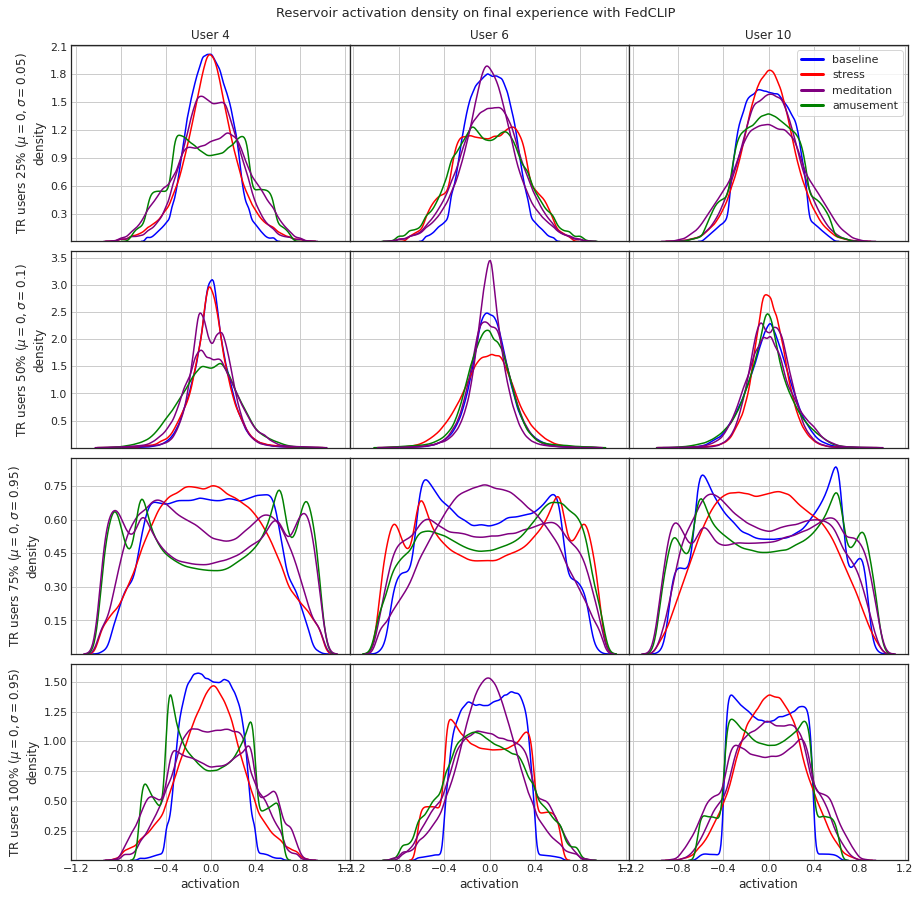

In [72]:
curr_plot, fig = plot_density_continual_final("WESAD", "continual_fedip", "replay")
plt.savefig(
    os.path.join(base_dir, f"img/{method}_{strategy}_final.png"),
    dpi=300, 
    bbox_inches='tight')
curr_plot.show()

In [27]:
import json, torch
def get_cont_str_res(method: str, dataset: str, perc: int):
    if "continual_ip" in method:
        exp_dir = (os.path.join(base_dir, "centralized"))
    else:
        exp_dir = exp_dir = (os.path.join(base_dir, "federated"))
    exp_dir = os.path.join(exp_dir, f"{method}/{dataset}/{perc}")
    res_file = os.path.join(exp_dir, "results.json")
    res = json.load(open(res_file))
    res = [res[i][-1]["stream"] for i in range(len(res))]
    res_str = (
        r"\res{"
        + str(round(np.mean(res) * 100, 2))
        + r"}{"
        + str(round(np.std(res) * 100, 2))
        + "}"
    )
    return res_str


In [31]:
method = "continual_fedip"

for perc in [25, 50, 75, 100]:
    line = [f"{perc}\\%"]
    for dataset in ["WESAD", "HHAR"]:
        for strategy in ["naive", "replay", "joint"]:
            line.append(get_cont_str_res("_".join([method, strategy]), dataset, perc))
    print(" & ".join(line) + r" \\")


25\% & \res{27.32}{10.86} & \res{79.23}{0.44} & \res{78.75}{0.67} & \res{34.85}{3.08} & \res{51.16}{5.88} & \res{69.44}{0.38} \\
50\% & \res{30.6}{7.51} & \res{77.49}{0.89} & \res{75.95}{1.07} & \res{30.16}{2.1} & \res{43.77}{1.5} & \res{60.85}{4.37} \\
75\% & \res{51.5}{4.1} & \res{77.04}{0.89} & \res{78.17}{0.54} & \res{28.62}{0.93} & \res{59.83}{0.88} & \res{71.14}{0.84} \\
100\% & \res{50.8}{1.5} & \res{77.46}{1.31} & \res{79.51}{0.35} & \res{30.3}{0.43} & \res{62.28}{0.54} & \res{71.22}{0.32} \\
